# Image Segmentation on Forest Imagery

CSC 522 Fall 2024

- Anthony Wu, awu3
- Jheel Gala, jgala	
- Ophelia Sin, oysin
- Venkata Sai Praveen Gunda, vgunda



In [3]:
### import required packages

import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## Data Preprocessing

In [9]:
base_dir = 'data'
#base_dir = 'data_new'

original_dir = os.path.join(base_dir, 'original')
mask_dir = os.path.join(base_dir, 'mask')


In [10]:
# Load and preprocess original image

def load_and_preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)  
    img = tf.image.resize(img, [224, 224])  
    img = img / 255.0  # Normalize pixel values to [0, 1]
    return img

In [11]:
# Load mask

def load_mask(mask_path):
    mask = tf.io.read_file(mask_path)
    
    # Decode PNG image, keeping all channels (including alpha)
    mask = tf.image.decode_png(mask, channels=4)  # RGBA (4 channels)

    # Extract the alpha channel (transparency)
    alpha_channel = mask[:, :, 3]  # Alpha channel is the 4th channel

    # Create a binary mask: 1 for opaque (non-transparent), 0 for transparent
    binary_mask = tf.cast(alpha_channel > 0, tf.float32)

    # Resize the binary mask to match (224x224)
    binary_mask = tf.image.resize(binary_mask[..., tf.newaxis], [224, 224], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return binary_mask

In [12]:
# Function to load both image and mask together
def load_image_and_mask(image_path, mask_path):
    image = load_and_preprocess_image(image_path)
    mask = load_mask(mask_path)
    return image, mask

In [13]:
# Get list of all images and masks
original_paths = sorted([os.path.join(original_dir, fname) for fname in os.listdir(original_dir)])
mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])

In [14]:
# Create TensorFlow Dataset from the file paths of original images and masks
dataset = tf.data.Dataset.from_tensor_slices((original_paths, mask_paths))
print(dataset.element_spec)
buffer_size = 1000
dataset = dataset.shuffle(buffer_size)
dataset = dataset.map(load_image_and_mask)

(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))


In [15]:
# Split the dataset into training, validation, and test datasets
total_count = len(list(dataset))
train_count = int(0.7 * total_count)
validation_count = int(0.1 * total_count)
test_count = int(0.2 * total_count)


train_dataset = dataset.take(train_count)
remaining = dataset.skip(train_count)
val_dataset = remaining.take(validation_count)
test_dataset = remaining.skip(validation_count)

2024-11-26 17:10:49.455028: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:10:49.468850: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:10:49.473833: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:10:49.480639: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:10:49.492098: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:10:49.492868: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:10:49.494838: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:10:49.497445: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:10:49.498543: W tensorflow/core/lib/png/png_io.cc:89] PNG 

## Prepare for Modeling

In [16]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.Sequential([
            tf.keras.layers.RandomFlip(mode="horizontal", seed=seed),
            tf.keras.layers.RandomRotation(0.2, seed=seed),
            tf.keras.layers.RandomZoom(0.2, seed=seed)
        ])
        
    self.augment_labels = tf.keras.Sequential([
        tf.keras.layers.RandomFlip(mode="horizontal", seed=seed),
        tf.keras.layers.RandomRotation(0.2, seed=seed),
        tf.keras.layers.RandomZoom(0.2, seed=seed)
    ])

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [17]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000

In [18]:
train_batches = (
    train_dataset
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

# Prepare the validation dataset without data augmentation
validation_batches = (
    val_dataset
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Prepare the test dataset without data augmentation
test_batches = (
    test_dataset
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [19]:
from tensorflow_examples.models.pix2pix import pix2pix

# Pretrained network
base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False)

In [20]:
# base_model.summary()

## Default Architecture

In [21]:
# Specific layers in MobileNetV2
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project'      # 4x4
]

# Get output layers corresponding to the layer names
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create submodel of MobileNetV2 

# Intermediate computations still present in model. These layers are still computing the fetaure maps fro the selected layers.  
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

# Freezing Weights for Pretrained Model

# ❗️play with the model layers that I want to freeze 
# code would look something like:
# for layer in down_stack.layers[:-23]: # freeze all layers except the last 23
#     layer.trainable = False

down_stack.trainable = False


In [22]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [23]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[224, 224, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1] # last feature map from the downstack 
  skips = reversed(skips[:-1]) # all the feature maps except the last one are reversed and stored in skips, so that we can use them for skip connections

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  last = tf.keras.layers.Conv2DTranspose(
    filters=output_channels, kernel_size=3, strides=2,
    padding='same', activation='sigmoid',
    kernel_regularizer=tf.keras.regularizers.l2(0.001)  # L2 regularization
  )

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

OUTPUT_CLASSES = 1
model=unet_model(output_channels=OUTPUT_CLASSES)

In [ ]:
def iou_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Convert predictions to binary
    intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=[1, 2, 3])
    union = tf.reduce_sum(y_true,[1, 2, 3]) + tf.reduce_sum(y_pred,[1, 2, 3]) - intersection
    iou = tf.where(
        tf.equal(union, 0),  # Check where the union is zero
        1 - (tf.reduce_sum(y_pred, axis=[1, 2, 3]) / 244**2),  # Special case calculation
        intersection / union  # Regular IoU calculation
    )
    return iou

In [25]:
model.compile(optimizer='adam', #❗️specify learning rate
              loss='binary_crossentropy',
              metrics=['accuracy', iou_metric])

### Training with 1-Fold

In [172]:
EPOCHS = 20
VAL_SUBSPLITS = 5
steps_per_epoch = train_count // BATCH_SIZE
validation_steps = validation_count // BATCH_SIZE

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

history = model.fit(
    train_batches,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_batches,
    validation_steps=validation_steps,
    callbacks=[callback, lr_schedule]
)

Epoch 1/20


2024-11-26 15:08:10.346861: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 15:08:10.351506: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 15:08:10.352738: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 15:08:10.358834: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 15:08:10.361310: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 15:08:10.364612: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 15:08:10.366804: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 15:08:10.368495: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 15:08:10.372876: W tensorflow/core/lib/png/png_io.cc:89] PNG 

KeyboardInterrupt: 

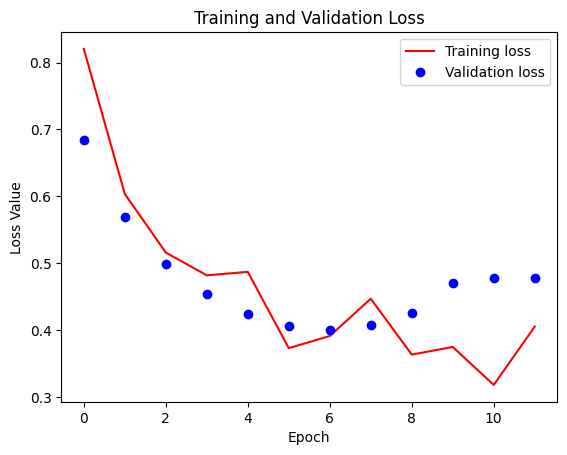

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(history.epoch, loss, 'r', label='Training loss')
plt.plot(history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
# plt.ylim([0, 1])
plt.legend()
plt.show()

#### Predictions

In [ ]:
predicted = model.predict(test_batches)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


In [ ]:
predicted_masks = (predicted>0.6).astype(int)

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy, test_iou = model.evaluate(test_batches)

print(f"Test Loss: {test_loss}")
print(f"Test IOU: {test_iou}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step - accuracy: 0.8855 - iou_metric: 0.4316 - loss: 0.3348
Test Loss: 0.33477717638015747
Test IOU: 0.43157893419265747
Test Accuracy: 88.55%


In [ ]:
import matplotlib.pyplot as plt

# Function to display images, ground truth masks, and predicted masks
def display_sample(image, ground_truth, prediction):
    plt.figure(figsize=(10, 10))

    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(image)

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(ground_truth, cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Prediction")
    plt.imshow(prediction, cmap='gray')

    plt.show()

In [ ]:
# Iterate through the test dataset and display results
def display_results(model, test_dataset, threshold=0.5):
    for images, masks in test_dataset.take(5):
        preds = model.predict(images)
        predicted_masks = (preds>threshold).astype(np.uint8)
        for i in range(len(images)):
            display_sample(images[i].numpy(), masks[i].numpy().squeeze(), predicted_masks[i].squeeze())

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


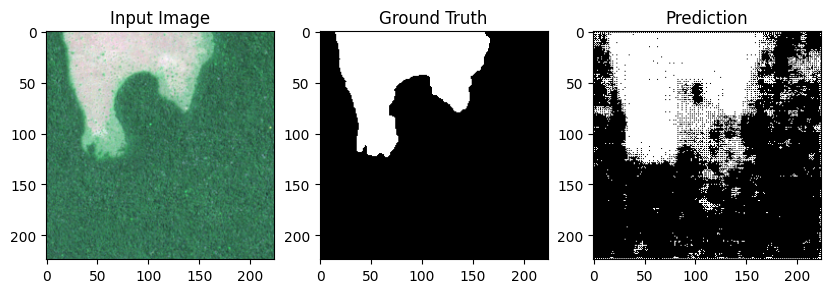

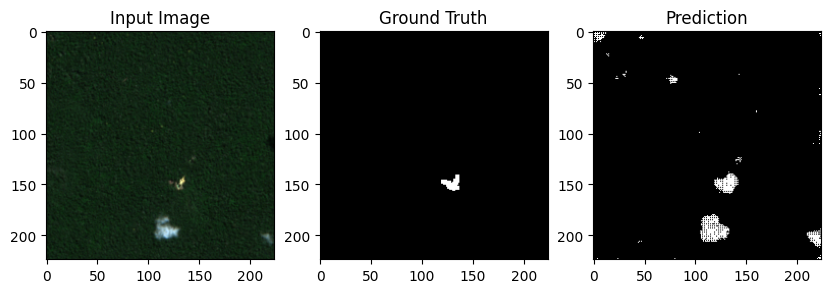

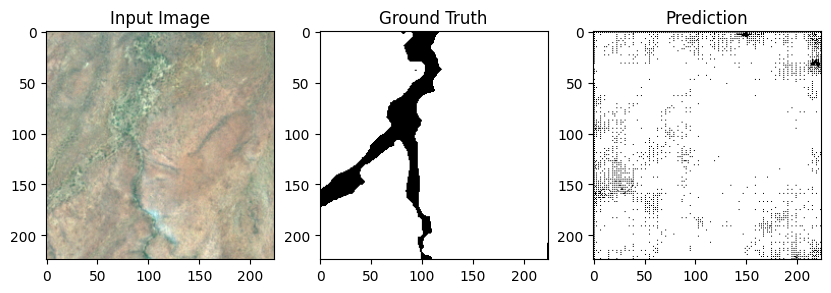

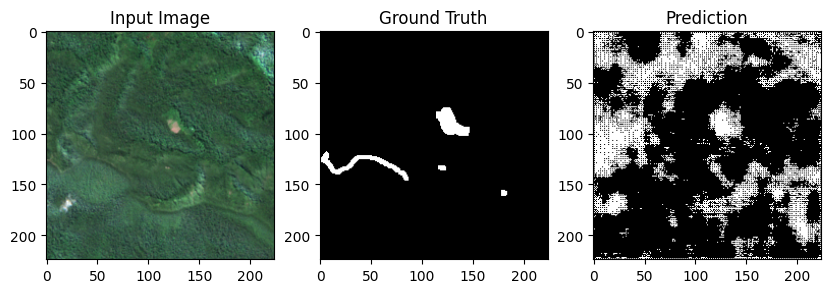

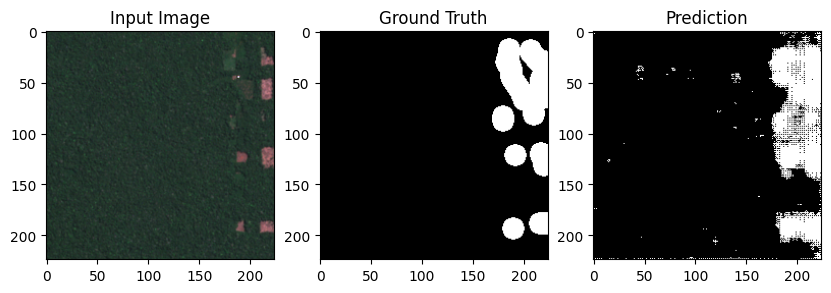

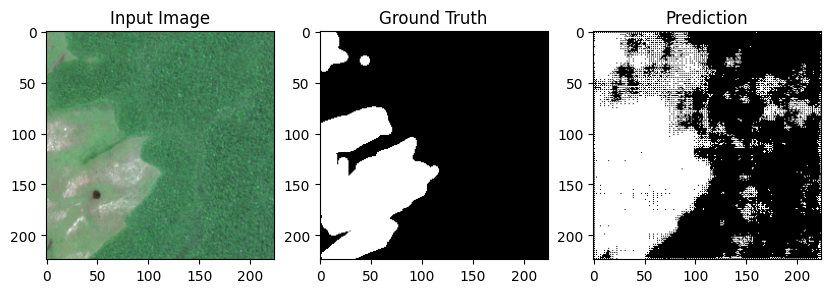

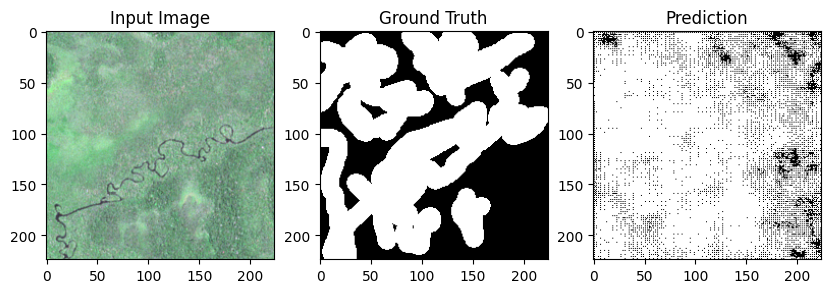

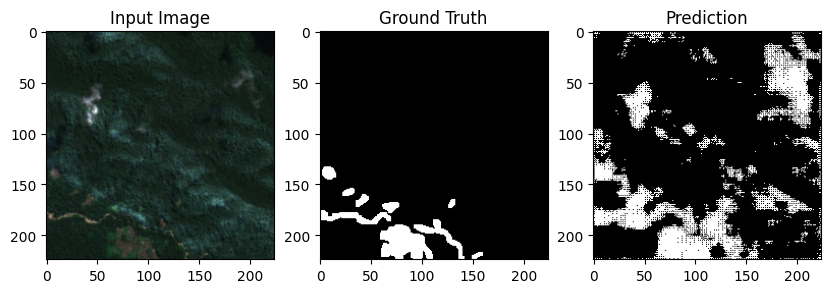

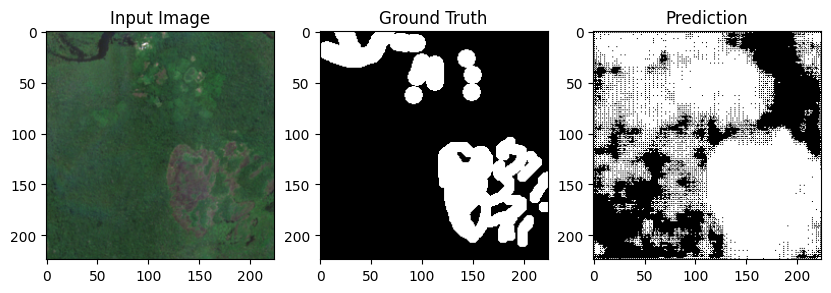

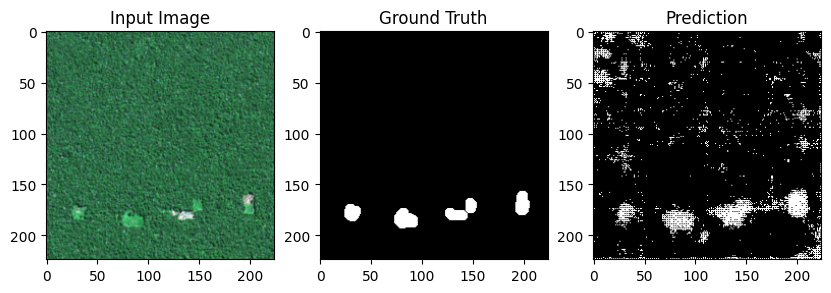

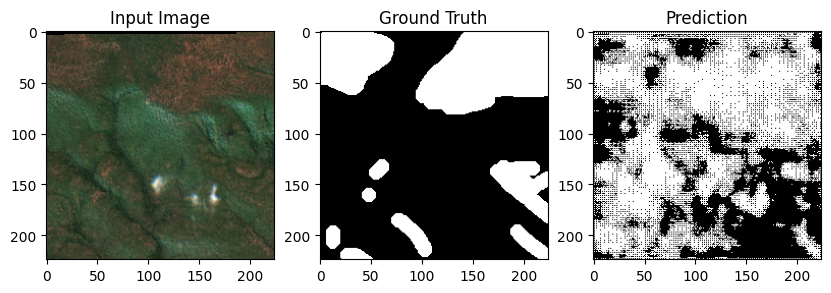

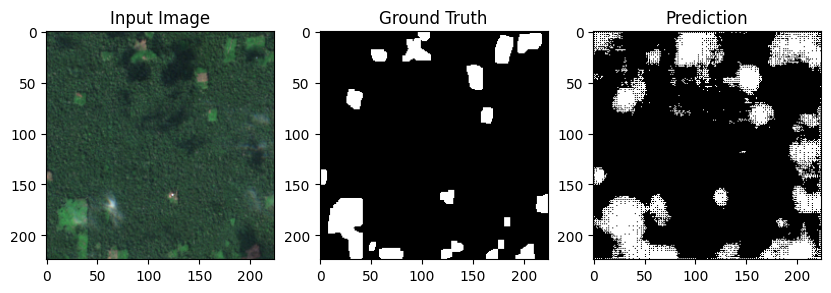

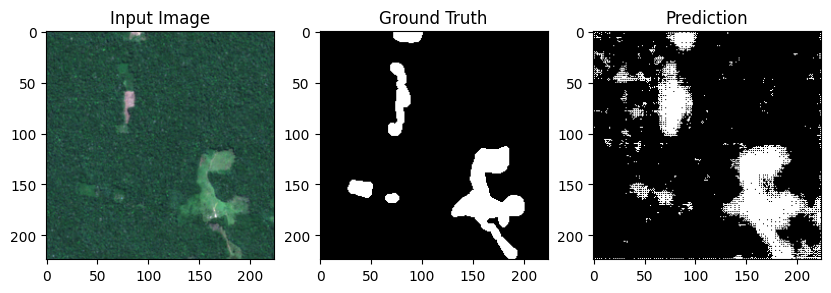

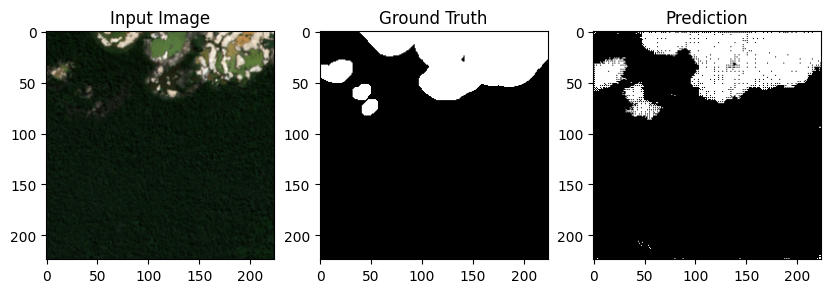

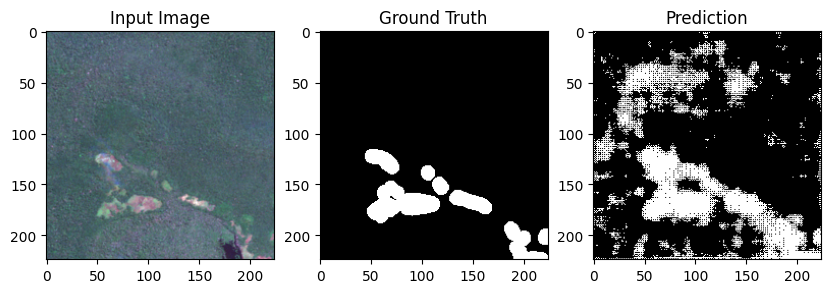

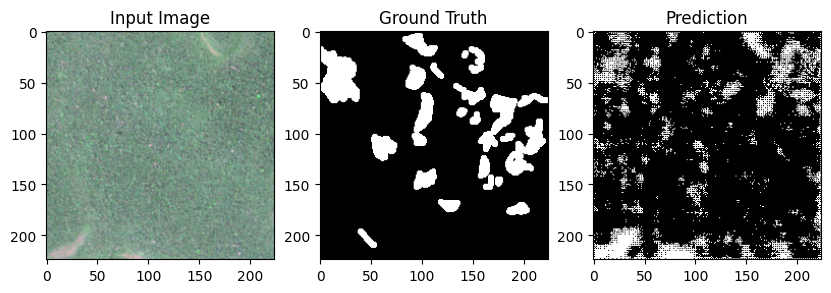

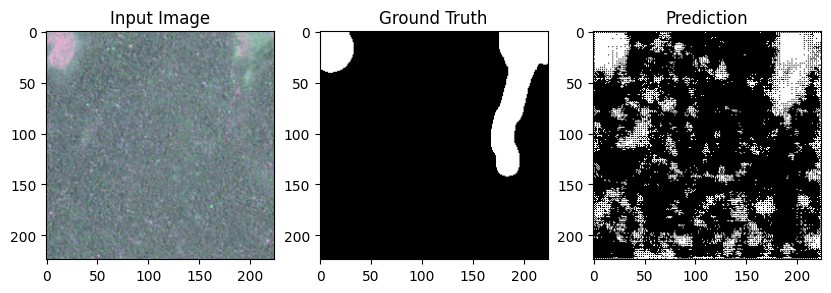

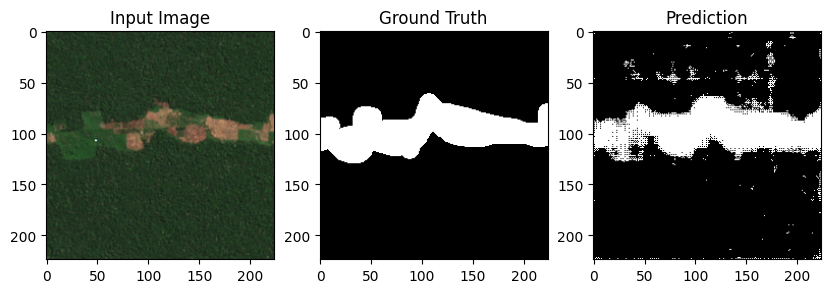

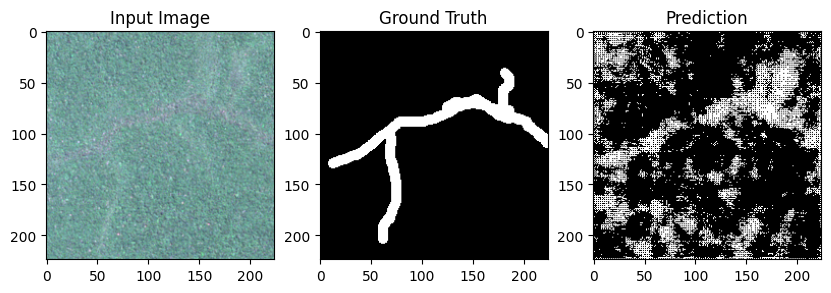

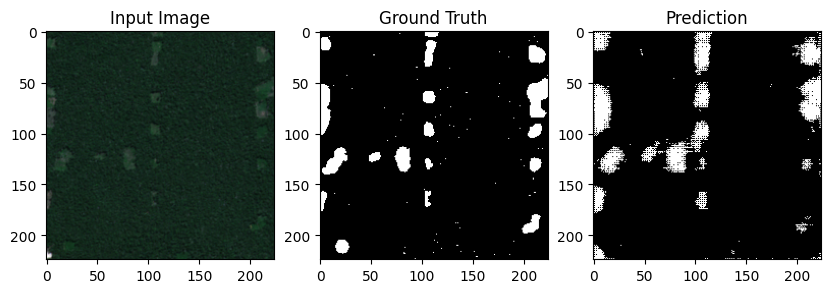

In [ ]:
display_results(model, test_batches, threshold=0.6)

### K-Fold Cross Validation

In [ ]:
from sklearn.model_selection import KFold

# Number of folds
k_folds = 5
EPOCHS = 20
BATCH_SIZE = 32
steps_per_epoch = train_count // BATCH_SIZE
validation_steps = validation_count // BATCH_SIZE

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

# Concatenate train_dataset and val_dataset to create a full training dataset for K-fold
train_dataset_full = train_dataset.concatenate(val_dataset)

# Initialize KFold from scikit-learn
kf = KFold(n_splits=k_folds, shuffle=True)

k_fold_results = []
# Loop over each fold
for fold in range(k_folds):
    print(f"Training fold {fold + 1}/{k_folds}...")

    # Split dataset into training and validation sets for this fold
    # train_data = [dataset_list[i] for i in train_idx]
    # val_data = [dataset_list[i] for i in val_idx]

    train_dataset_full_copy = train_dataset_full
    # Shard the dataset for training and validation sets
    def get_train_val_datasets(dataset, fold_num, num_folds):

        # Validation set: shard corresponding to this fold number
        val_dataset = dataset.shard(num_shards=num_folds, index=fold_num)
        
        # Training set: all other shards except the current fold number (using filter)
        train_dataset = dataset.enumerate().filter(lambda i, _: i % num_folds != fold_num).map(lambda _, data: data)

        return train_dataset, val_dataset
    
    # Remove index from datasets (if added)
    train_dataset, val_dataset = get_train_val_datasets(train_dataset_full_copy, fold, k_folds)
        
    # Convert lists back to tf.data.Dataset objects
    train_dataset = (train_dataset
        .batch(BATCH_SIZE)
        .cache()
        .shuffle(BUFFER_SIZE)
        .map(Augment())
        .repeat()
        .prefetch(buffer_size=tf.data.AUTOTUNE))
    
    val_dataset = (val_dataset
        .batch(BATCH_SIZE)
        .cache()
        .map(Augment())
        .prefetch(buffer_size=tf.data.AUTOTUNE))

    model = unet_model(output_channels=1)

    # Compile the model with appropriate loss function and metrics
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', iou_metric])  

    # Train the model on this fold's training data
    history = model.fit(
        train_dataset,
        steps_per_epoch=steps_per_epoch,
        epochs=EPOCHS,
        validation_data=val_dataset,
        validation_steps=validation_steps,
        callbacks=[callback, lr_schedule],
        verbose = 0
    )

    train_accuracy = history.history['accuracy'][-1]      
    train_iou = history.history['iou_metric'][-1]          
    train_loss = history.history['loss'][-1]              

    val_accuracy = history.history['val_accuracy'][-1]     
    val_iou = history.history['val_iou_metric'][-1]       
    val_loss = history.history['val_loss'][-1]            

    k_fold_results.append({
        'fold': fold + 1,
        'train_accuracy': train_accuracy,
        'train_iou': train_iou,
        'train_loss': train_loss,
        'val_accuracy': val_accuracy,
        'val_iou': val_iou,
        'val_loss': val_loss
    })

    print(k_fold_results[-1])

2024-11-26 17:11:07.110889: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:11:07.111787: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:11:07.119280: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:11:07.121066: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:11:07.123488: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:11:07.127424: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:11:07.133251: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:11:07.136446: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:11:07.141228: W tensorflow/core/lib/png/png_io.cc:89] PNG 

Training fold 1/5...


2024-11-26 17:11:09.910153: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:11:09.913992: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:11:09.914895: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:11:09.924078: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:11:09.925077: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:11:09.927781: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:11:09.928745: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:11:09.929852: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:11:09.934980: W tensorflow/core/lib/png/png_io.cc:89] PNG 

{'fold': 1, 'train_accuracy': 0.793528139591217, 'train_iou': 0.2312932163476944, 'train_loss': 0.391131728887558, 'val_accuracy': 0.741129994392395, 'val_iou': 0.2653292417526245, 'val_loss': 0.5189003348350525}
Training fold 2/5...


2024-11-26 17:11:56.015214: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:11:56.015257: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:11:56.019454: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:11:56.040812: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:11:56.046597: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:11:56.049583: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:11:56.052946: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:11:56.053490: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:11:56.055755: W tensorflow/core/lib/png/png_io.cc:89] PNG 

{'fold': 2, 'train_accuracy': 0.8127630352973938, 'train_iou': 0.2443702071905136, 'train_loss': 0.39547809958457947, 'val_accuracy': 0.6848852634429932, 'val_iou': 0.2682117521762848, 'val_loss': 0.5635953545570374}
Training fold 3/5...


2024-11-26 17:12:42.244304: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:12:42.250115: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:12:42.254902: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:12:42.259104: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:12:42.260168: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:12:42.262267: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:12:42.264725: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:12:42.267393: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:12:42.267514: W tensorflow/core/lib/png/png_io.cc:89] PNG 

{'fold': 3, 'train_accuracy': 0.7607539296150208, 'train_iou': 0.023316755890846252, 'train_loss': 0.4717126190662384, 'val_accuracy': 0.7727213501930237, 'val_iou': 0.24523989856243134, 'val_loss': 0.5034933090209961}
Training fold 4/5...


2024-11-26 17:13:09.427611: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:13:09.432163: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:13:09.436100: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:13:09.442888: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:13:09.443278: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:13:09.444598: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:13:09.444849: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:13:09.447280: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:13:09.449843: W tensorflow/core/lib/png/png_io.cc:89] PNG 

{'fold': 4, 'train_accuracy': 0.8539403676986694, 'train_iou': 0.32743796706199646, 'train_loss': 0.290355384349823, 'val_accuracy': 0.8271802663803101, 'val_iou': 0.43890225887298584, 'val_loss': 0.3412300944328308}
Training fold 5/5...


2024-11-26 17:14:36.355997: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:14:36.356185: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:14:36.356201: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:14:36.358103: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:14:36.363234: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:14:36.365026: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:14:36.372217: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:14:36.374129: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 17:14:36.377071: W tensorflow/core/lib/png/png_io.cc:89] PNG 

{'fold': 5, 'train_accuracy': 0.766743004322052, 'train_iou': 0.03037373349070549, 'train_loss': 0.48718950152397156, 'val_accuracy': 0.7724370360374451, 'val_iou': 0.22063568234443665, 'val_loss': 0.5221811532974243}


In [28]:
for i in k_fold_results:
    print(i)

{'fold': 1, 'train_accuracy': 0.793528139591217, 'train_iou': 0.2312932163476944, 'train_loss': 0.391131728887558, 'val_accuracy': 0.741129994392395, 'val_iou': 0.2653292417526245, 'val_loss': 0.5189003348350525}
{'fold': 2, 'train_accuracy': 0.8127630352973938, 'train_iou': 0.2443702071905136, 'train_loss': 0.39547809958457947, 'val_accuracy': 0.6848852634429932, 'val_iou': 0.2682117521762848, 'val_loss': 0.5635953545570374}
{'fold': 3, 'train_accuracy': 0.7607539296150208, 'train_iou': 0.023316755890846252, 'train_loss': 0.4717126190662384, 'val_accuracy': 0.7727213501930237, 'val_iou': 0.24523989856243134, 'val_loss': 0.5034933090209961}
{'fold': 4, 'train_accuracy': 0.8539403676986694, 'train_iou': 0.32743796706199646, 'train_loss': 0.290355384349823, 'val_accuracy': 0.8271802663803101, 'val_iou': 0.43890225887298584, 'val_loss': 0.3412300944328308}
{'fold': 5, 'train_accuracy': 0.766743004322052, 'train_iou': 0.03037373349070549, 'train_loss': 0.48718950152397156, 'val_accuracy': 

####  Predictions

In [117]:
test_dataset = (test_dataset
                .batch(BATCH_SIZE)  # Ensure batching
                .prefetch(buffer_size=tf.data.AUTOTUNE))

In [123]:
predicted_k_fold = model.predict(test_batches)
predicted_masks_k_fold = (predicted_k_fold>0.4).astype(int)

2024-11-26 14:54:44.237926: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 14:54:44.244982: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 14:54:44.249153: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 14:54:44.253336: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 14:54:44.256024: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 14:54:44.260919: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 14:54:44.264295: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 14:54:44.269950: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 14:54:44.276089: W tensorflow/core/lib/png/png_io.cc:89] PNG 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


In [125]:
# Evaluate the model on the test dataset
test_loss, test_accuracy, test_iou = model.evaluate(test_batches)

print(f"Test Loss: {test_loss}")
print(f"Test IOU: {test_iou}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step - accuracy: 0.7811 - iou_metric: 5.3187e-04 - loss: 0.5649
Test Loss: 0.5649217367172241
Test IOU: 0.0005318708717823029
Test Accuracy: 78.11%


In [1]:
display_results(model, test_batches, threshold=0.5)

NameError: name 'display_results' is not defined

## Experiment with freezing layers

In [ ]:
def unfreeze_layers(model, layers_to_unfreeze):
    for layer in model.layers:
        if layer.name in layers_to_unfreeze:
            layer.trainable = True  # Unfreeze the layer
        else:
            layer.trainable = False  
    print(f"Unfrozen layers: {layers_to_unfreeze}")

In [ ]:
# Function to progressively unfreeze deeper to shallower layers
def progressively_unfreeze_layers(down_stack, unfreeze_depths):
    models = []
    
    for depth, layers_to_unfreeze in enumerate(unfreeze_depths):
        # Clone the downstack to avoid modifying the original
        cloned_down_stack = tf.keras.models.clone_model(down_stack)
        
        # Unfreeze the specified layers
        unfreeze_layers(cloned_down_stack, layers_to_unfreeze)
        
        # Add the modified downstack to the list of models
        models.append(cloned_down_stack)
        
        print(f"Experiment {depth + 1}: Unfrozen {len(layers_to_unfreeze)} layers.")
    
    return models

In [59]:
def unet_model_unfreeze(output_channels:int, down_stack):
  inputs = tf.keras.layers.Input(shape=[224, 224, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1] # last feature map from the downstack 
  skips = reversed(skips[:-1]) # all the feature maps except the last one are reversed and stored in skips, so that we can use them for skip connections

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  last = tf.keras.layers.Conv2DTranspose(
    filters=output_channels, kernel_size=3, strides=2,
    padding='same', activation='sigmoid',
    kernel_regularizer=tf.keras.regularizers.l2(0.001)  # L2 regularization
  )

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
# Define unfrozen layers
unfreeze_depths = [
    ['block_16_project'],                                  
    ['block_16_project', 'block_13_expand_relu'],          
    ['block_16_project', 'block_13_expand_relu', 'block_6_expand_relu'],  
    ['block_16_project', 'block_13_expand_relu', 'block_6_expand_relu', 'block_3_expand_relu'],  
    ['block_16_project', 'block_13_expand_relu', 'block_6_expand_relu', 'block_3_expand_relu', 'block_1_expand_relu'] 
]

# Create progressively unfrozen models
progressively_unfrozen_models = progressively_unfreeze_layers(down_stack, unfreeze_depths)

Unfrozen layers: ['block_16_project']
Experiment 1: Unfrozen 1 layers.
Unfrozen layers: ['block_16_project', 'block_13_expand_relu']
Experiment 2: Unfrozen 2 layers.
Unfrozen layers: ['block_16_project', 'block_13_expand_relu', 'block_6_expand_relu']
Experiment 3: Unfrozen 3 layers.
Unfrozen layers: ['block_16_project', 'block_13_expand_relu', 'block_6_expand_relu', 'block_3_expand_relu']
Experiment 4: Unfrozen 4 layers.
Unfrozen layers: ['block_16_project', 'block_13_expand_relu', 'block_6_expand_relu', 'block_3_expand_relu', 'block_1_expand_relu']
Experiment 5: Unfrozen 5 layers.


In [66]:
EPOCHS = 30
VAL_SUBSPLITS = 5
OUTPUT_CLASSES = 1

steps_per_epoch = train_count // BATCH_SIZE
validation_steps = validation_count // BATCH_SIZE

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

results = []

for i, encoder_model in enumerate(progressively_unfrozen_models):
    print(f"\nModel {i + 1}: Trainable Layers")
    for layer in encoder_model.layers:
        if layer.trainable:
            print(layer.name)
    
    # Compile model
    model=unet_model_unfreeze(output_channels=OUTPUT_CLASSES, down_stack = encoder_model)

    model.compile(optimizer='adam', #❗️specify learning rate
              loss='binary_crossentropy',
              metrics=['accuracy', iou_metric])
    
    # Train
    history = model.fit(
        train_batches,
        steps_per_epoch=steps_per_epoch,
        epochs=EPOCHS,
        validation_data=validation_batches,
        validation_steps=validation_steps,
        verbose = 0,
        callbacks=[callback, lr_schedule]
    )

    train_accuracy = history.history['accuracy'][-1]      
    train_iou = history.history['iou_metric'][-1]          
    train_loss = history.history['loss'][-1]              

    val_accuracy = history.history['val_accuracy'][-1]     
    val_iou = history.history['val_iou_metric'][-1]       
    val_loss = history.history['val_loss'][-1]            

    # print(f"\nModel {i + 1}: Layer Structure AFTER unet_model_unfreeze")
    # for layer in model.layers:
    #     print(f"Layer Name: {layer.name}, Trainable: {layer.trainable}")
            
    results.append({
        'model': i + 1,
        'train_accuracy': train_accuracy,
        'train_iou': train_iou,
        'train_loss': train_loss,
        'val_accuracy': val_accuracy,
        'val_iou': val_iou,
        'val_loss': val_loss
    })

    print(results[-1])



Model 1: Trainable Layers
block_16_project
{'model': 1, 'train_accuracy': 0.765967845916748, 'train_iou': nan, 'train_loss': 0.516269326210022, 'val_accuracy': 0.8048779368400574, 'val_iou': 0.0, 'val_loss': 0.543792724609375}

Model 2: Trainable Layers
block_13_expand_relu
block_16_project
{'model': 2, 'train_accuracy': 0.7826656103134155, 'train_iou': nan, 'train_loss': 0.5535923838615417, 'val_accuracy': 0.8048779368400574, 'val_iou': 0.0, 'val_loss': 0.5955639481544495}

Model 3: Trainable Layers
block_6_expand_relu
block_13_expand_relu
block_16_project
{'model': 3, 'train_accuracy': 0.8165537714958191, 'train_iou': nan, 'train_loss': 0.49274149537086487, 'val_accuracy': 0.8048779368400574, 'val_iou': 0.0, 'val_loss': 0.5616241693496704}

Model 4: Trainable Layers
block_3_expand_relu
block_6_expand_relu
block_13_expand_relu
block_16_project
{'model': 4, 'train_accuracy': 0.7572891712188721, 'train_iou': nan, 'train_loss': 0.5748522877693176, 'val_accuracy': 0.8048779368400574, 'va

## Final decision: freezing 3 layers

In [67]:
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project'      # 4x4
]

# Get output layers corresponding to the layer names
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create submodel of MobileNetV2 

# Intermediate computations still present in model. These layers are still computing the fetaure maps fro the selected layers.  
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

layers_to_unfreeze = ['block_16_project', 'block_13_expand_relu', 'block_6_expand_relu']
for layer in down_stack.layers:
    if layer.name in layers_to_unfreeze:
        layer.trainable = True 
    else:
        layer.trainable = False 

In [68]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[224, 224, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1] # last feature map from the downstack 
  skips = reversed(skips[:-1]) # all the feature maps except the last one are reversed and stored in skips, so that we can use them for skip connections

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  last = tf.keras.layers.Conv2DTranspose(
    filters=output_channels, kernel_size=3, strides=2,
    padding='same', activation='sigmoid',
    kernel_regularizer=tf.keras.regularizers.l2(0.001)  # L2 regularization
  )

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

OUTPUT_CLASSES = 1
model=unet_model(output_channels=OUTPUT_CLASSES)

In [69]:
model.compile(optimizer='adam', #❗️specify learning rate
              loss='binary_crossentropy',
              metrics=['accuracy', iou_metric])

In [70]:
EPOCHS = 30
VAL_SUBSPLITS = 5
steps_per_epoch = train_count // BATCH_SIZE
validation_steps = validation_count // BATCH_SIZE

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

history = model.fit(
    train_batches,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_batches,
    validation_steps=validation_steps,
    callbacks=[callback, lr_schedule]
)

Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.3664 - iou_metric: 0.1663 - loss: 0.8763 - val_accuracy: 0.6045 - val_iou_metric: 0.1194 - val_loss: 1.2233 - learning_rate: 0.0010
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6251 - iou_metric: 0.1011 - loss: 0.6146 - val_accuracy: 0.7290 - val_iou_metric: 0.0760 - val_loss: 0.8491 - learning_rate: 0.0010
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 409ms/step - accuracy: 0.6940 - iou_metric: 0.0797 - loss: 0.5395 - val_accuracy: 0.7560 - val_iou_metric: 0.0535 - val_loss: 0.6997 - learning_rate: 0.0010
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.7741 - iou_metric: 0.0430 - loss: 0.5024 - val_accuracy: 0.7796 - val_iou_metric: 0.0364 - val_loss: 0.5774 - learning_rate: 0.0010
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7263 - iou_metric: 0.0119 - loss: 0.5776 - val_accuracy: 0.8041 - val_iou_metric: 0.0262 - val_loss: 0.4787 - learning_rate: 0.0010
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━

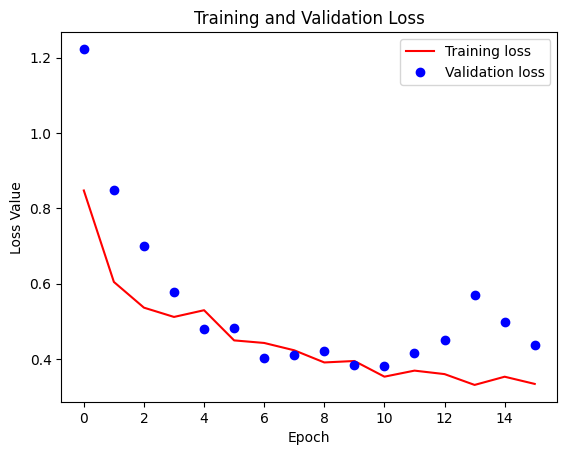

In [75]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(history.epoch, loss, 'r', label='Training loss')
plt.plot(history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
# plt.ylim([0, 1])
plt.legend()
plt.show()

In [72]:
predicted = model.predict(test_batches)
predicted_masks = (predicted>0.6).astype(int)

2024-11-26 14:35:50.211350: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 14:35:50.211851: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 14:35:50.212097: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 14:35:50.212500: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 14:35:50.222076: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 14:35:50.223759: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 14:35:50.232805: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 14:35:50.236360: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 14:35:50.237004: W tensorflow/core/lib/png/png_io.cc:89] PNG 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [73]:
# Evaluate the model on the test dataset
test_loss, test_accuracy, test_iou = model.evaluate(test_batches)

print(f"Test Loss: {test_loss}")
print(f"Test IOU: {test_iou}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step - accuracy: 0.8179 - iou_metric: 0.2012 - loss: 0.5149
Test Loss: 0.5149226784706116
Test IOU: 0.20118586719036102
Test Accuracy: 81.79%


In [2]:
display_results(model, test_batches, threshold=0.5)

NameError: name 'display_results' is not defined